# Example: LFPy plus .swc morphology file

Example utilizing the **`LFPykit`** module for predictions of extracellular potentials using 
the line source approximation implementation `LineSourcePotential` with a passive neuron model set up in LFPy (https://lfpy.readthedocs.io, https://github.com/LFPy/LFPy). 

The neuron receives sinusoid synaptic current input in one arbitrary chosen segment. 
Its morphology is defined in the file `single_cell.swc`. 

The example produces comparable output as the `Example_Arbor_swc.ipynb` notebook. 
For this a couple of modified `CellGeometry` and `LineSourcePotential` classes have been defined below, similar to `Example_LFPy_pt3d.ipynb`

In [17]:
%matplotlib inline

In [18]:
## LFPy may be installed using pip:
#!pip install git+https://github.com/LFPy/LFPy.git

In [19]:
## if running on mybinder or similar, uncomment and run the following to install LFPykit. 
## Then restart the kernel.
#!pip install ..

In [20]:
# import modules
import numpy as np
import LFPy
import lfpykit
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

In [21]:
class Pt3dCellGeometry(lfpykit.CellGeometry):
    '''
    Class inherited from  ``lfpykit.CellGeometry`` for easier forward-model
    predictions in LFPy that keeps track of pt3d information
    for each compartment.

    Parameters
    ----------
    cell: ``LFPy.Cell`` object

    See also
    --------
    lfpykit.CellGeometry
    '''
    def __init__(self, cell):
        x, y, z, d = [np.array([], dtype=float).reshape((0, 2))] * 4
        c_ind = np.array([], dtype=int)  # tracks which compartment owns segment
        idx = 0
        for i, sec in enumerate(cell.allseclist):
            xp = (cell.arc3d[i] / cell.arc3d[i][-1])
            seg_l = 1 / sec.nseg / 2 
            for seg in sec:
                seg_x = np.array([seg.x - seg_l, seg.x + seg_l])
                ind = (xp > seg_x.min()) & (xp < seg_x.max())
                seg_x = np.sort(np.r_[seg_x, xp[ind]])
                
                # interpolate to get values for start-, pt3d-, and end-point for search segment:
                x_tmp = np.interp(seg_x, xp, cell.x3d[i])
                y_tmp = np.interp(seg_x, xp, cell.y3d[i])
                z_tmp = np.interp(seg_x, xp, cell.z3d[i])
                d_tmp = np.interp(seg_x, xp, cell.diam3d[i])
                
                # store
                x = np.row_stack([x, np.c_[x_tmp[:-1], x_tmp[1:]]])
                y = np.row_stack([y, np.c_[y_tmp[:-1], y_tmp[1:]]])
                z = np.row_stack([z, np.c_[z_tmp[:-1], z_tmp[1:]]])
                d = np.row_stack([d, np.c_[d_tmp[:-1], d_tmp[1:]]])
                
                c_ind = np.r_[c_ind, np.ones(seg_x.size - 1) * idx]
                idx += 1

        super().__init__(x=x, y=y, z=z, d=d)
        self._c_ind = c_ind

In [22]:
class Pt3dLineSourcePotential(lfpykit.LineSourcePotential):
    '''subclass of ``lfpykit.LineSourcePotential`` modified for
    instances of ``Pt3dCellGeometry``.
    Each compartment may consist of several segments, and this implementation
    accounts for their contributions normalized by surface area, that is,
    we assume constant transmembrane current density per area across each compartment
    and constant current source density per unit length per segment
    (inherent in the line-source approximation).

    Parameters
    ----------
    cell: object
        ``Pt3dCellGeometry`` instance or similar.
    x: ndarray of floats
        x-position of measurement sites (µm)
    y: ndarray of floats
        y-position of measurement sites (µm)
    z: ndarray of floats
        z-position of measurement sites (µm)
    sigma: float > 0
        scalar extracellular conductivity (S/m)

    See also
    --------
    lfpykit.LineSourcePotential
    '''

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._get_transformation_matrix = super().get_transformation_matrix

    def get_transformation_matrix(self):
        '''Get linear response matrix

        Returns
        -------
        response_matrix: ndarray
            shape (n_coords, n_CVs) ndarray
        '''
        M_tmp = self._get_transformation_matrix()
        n_comps = np.unique(self.cell._c_ind).size
        M = np.zeros((self.x.size, n_comps))
        for i in range(n_comps):
            inds = self.cell._c_ind == i
            M[:, i] = M_tmp[:, inds] @ (self.cell.area[inds] /
                                        self.cell.area[inds].sum())

        return M

In [23]:
def custom_fun(cell, nseg=3):
    # approximate the same cable discretization as the Arbor example w. nseg=3 per branch
    # except for the soma section
    for sec in cell.allseclist:
        if sec.name().rfind('soma') >= 0:
            pass
        else:
            sec.nseg = nseg    

In [24]:
cell = LFPy.Cell(
    morphology='single_cell.swc',
    cm=1.,     # membrane capacitance (uF/cm2)
    Ra=10000.,  # cytoplasmic resistivity (ohm cm)
    v_init=-65.,  # initial voltage (mV)
    passive=True,
    passive_parameters=dict(
        g_pas=0.0001, # leak conductivity (S/cm2)
        e_pas=-65),  # leak reversal potential
    nsegs_method=None,
    dt=0.1,
    tstop=500,
    pt3d=True,
    custom_fun=[custom_fun],
    custom_fun_args=[{}],
)


# cell.set_pos(0, 0, cell.length[0] / 2)
stim = LFPy.StimIntElectrode(cell, 
                             idx=cell.get_idx(section='apic[1]')[0],
                             pptype='SinSyn',
                             delay=0, 
                             freq=100, 
                             phase=np.pi)

# run simulation, record transmembrane currents and membrane potentials
cell.simulate(rec_imem=True, rec_vmem=True)

In [25]:
###############################################################################
# compute extracellular potential using pt3d information
###############################################################################

# locations where extracellular potential is predicted 
dx = 1
dz = 1
axis = np.round([cell.x.min()-10, cell.x.max()+10, cell.y.min()-10, cell.y.max()+10])
# axis = np.round(axis)
X, Y = np.meshgrid(np.linspace(axis[0], axis[1], int(np.diff(axis[:2]) // dx) + 1), 
                   np.linspace(axis[2], axis[3], int(np.diff(axis[2:]) // dz) + 1))
Z = np.zeros_like(X)

# create ``Pt3dCellGeometry`` instance
cell_geometry = Pt3dCellGeometry(cell)

# LineSourcePotential object, get mapping
lsp_pt3d = Pt3dLineSourcePotential(cell=cell_geometry,                                   
                                   x=X.flatten(), 
                                   y=Y.flatten(), 
                                   z=Z.flatten())
M = lsp_pt3d.get_transformation_matrix()

# Extracellular potential in x,z-plane coordinates   
V_e = M @ cell.imem

(-143.00076696500028,
 363.01610626500576,
 -76.67346928554844,
 66.70703218377005)

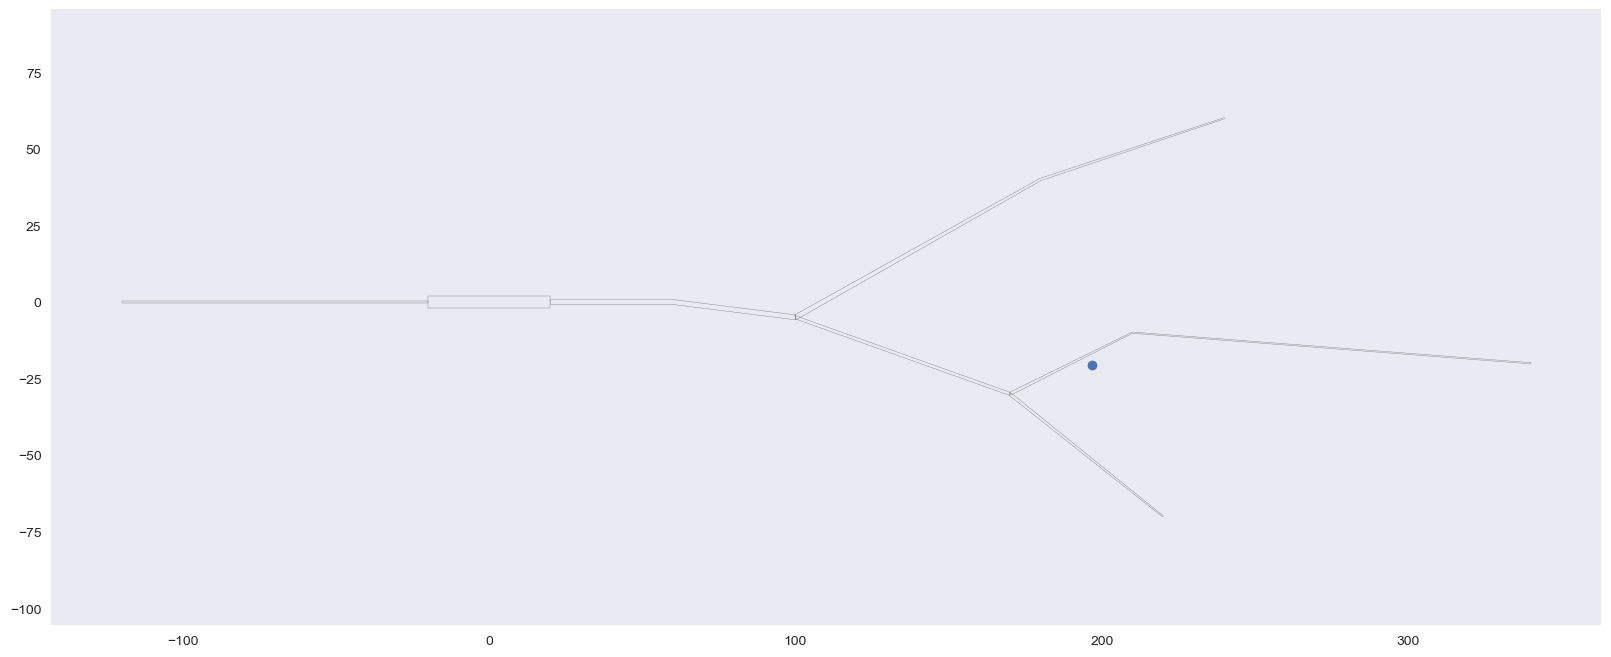

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
ax.grid(False)
zips = []
cell.diam3d = cell.diam3d * 5
for x, y in cell.get_idx_polygons(projection=('x', 'y')):
    zips.append(list(zip(x, y)))
polycol = PolyCollection(zips,
                         edgecolors='k',
                         facecolors='w')
    
zips = []
for x, y in cell.get_pt3d_polygons(projection=('x', 'y')):
    zips.append(list(zip(x, y)))
polycol = PolyCollection(zips,
                         edgecolors='gray',
                         facecolors='none')
ax.add_collection(polycol)


ax.plot(cell.x[stim.idx].mean(), cell.y[stim.idx].mean(), 'o')

ax.axis('equal')

## Plotting
Plot the morphology and extracellular potential prediction

In [27]:
def colorbar(fig, ax, im,
             width=0.01,
             height=1.0,
             hoffset=0.01,
             voffset=0.0,
             orientation='vertical'):
    '''
    draw matplotlib colorbar without resizing the axes object
    '''
    rect = np.array(ax.get_position().bounds)
    rect = np.array(ax.get_position().bounds)
    caxrect = [0] * 4
    caxrect[0] = rect[0] + rect[2] + hoffset * rect[2]
    caxrect[1] = rect[1] + voffset * rect[3]
    caxrect[2] = rect[2] * width
    caxrect[3] = rect[3] * height
    cax = fig.add_axes(caxrect)
    cax.grid(False)
    cb = fig.colorbar(im, cax=cax, orientation=orientation)
    return cb

In [28]:
def create_polygon(x, y, d):
    """create an outline for each segment defined by 1D arrays `x`, `y`, `d`
    in x,y-plane which can be drawn using `plt.Polygon`
    
    Parameters
    ----------
    x: ndarray
    y: ndarray
    d: ndarray
    
    Returns
    -------
    x, y: nested list
    """
    x_grad = np.gradient(x)
    y_grad = np.gradient(y)
    theta = np.arctan2(y_grad, x_grad)

    xp = np.r_[(x + 0.5 * d * np.sin(theta)).ravel(), (x - 0.5 * d * np.sin(theta)).ravel()[::-1]]
    yp = np.r_[(y - 0.5 * d * np.cos(theta)).ravel(), (y + 0.5 * d * np.cos(theta)).ravel()[::-1]]
    
    return list(zip(xp, yp))

In [29]:
def get_polycollection(
        cell_geometry, V_m, vlims=[-66, -64], cmap='viridis'):
    '''
    Parameters
    ----------
    cell_geometry: ``Pt3dCellGeometry`` like object
    V_m: ndarray
        membrane voltages at some time point
    vlims: list
        color limits
    cmap: str
        matplotlib colormap name

    Returns
    -------
    PolyCollection
    '''
    norm = plt.Normalize(vmin=vlims[0], vmax=vlims[1], clip=True)
    colors = [plt.get_cmap(cmap)(norm(v)) for v in V_m]
    zips = []
    for i in range(V_m.size):
        inds = cell_geometry._c_ind == i
        zips.append(create_polygon(cell_geometry.x[inds, ].flatten(),
                                   cell_geometry.y[inds, ].flatten(),
                                   cell_geometry.d[inds, ].flatten()))
    polycol = PolyCollection(zips,
                             edgecolors=colors,
                             facecolors=colors,
                             linewidths=0.)
    return polycol

In [30]:
def get_segment_outlines(cell_geometry):
    '''
    Parameters
    ----------
    cell_geometry: ``ArborCellGeometry`` object
    cmap: str
        matplotlib colormap name

    Returns
    -------
    PolyCollection
    '''
    zips = []
    for x_, y_, d_ in zip(cell_geometry.x, cell_geometry.y, cell_geometry.d):
        zips.append(create_polygon(x_, y_, d_))
    polycol = PolyCollection(zips,
                             edgecolors='k',
                             facecolors='none',
                             linewidths=0.5)
    return polycol

Text(0, 0.5, '$y$ ($\\mu$m)')

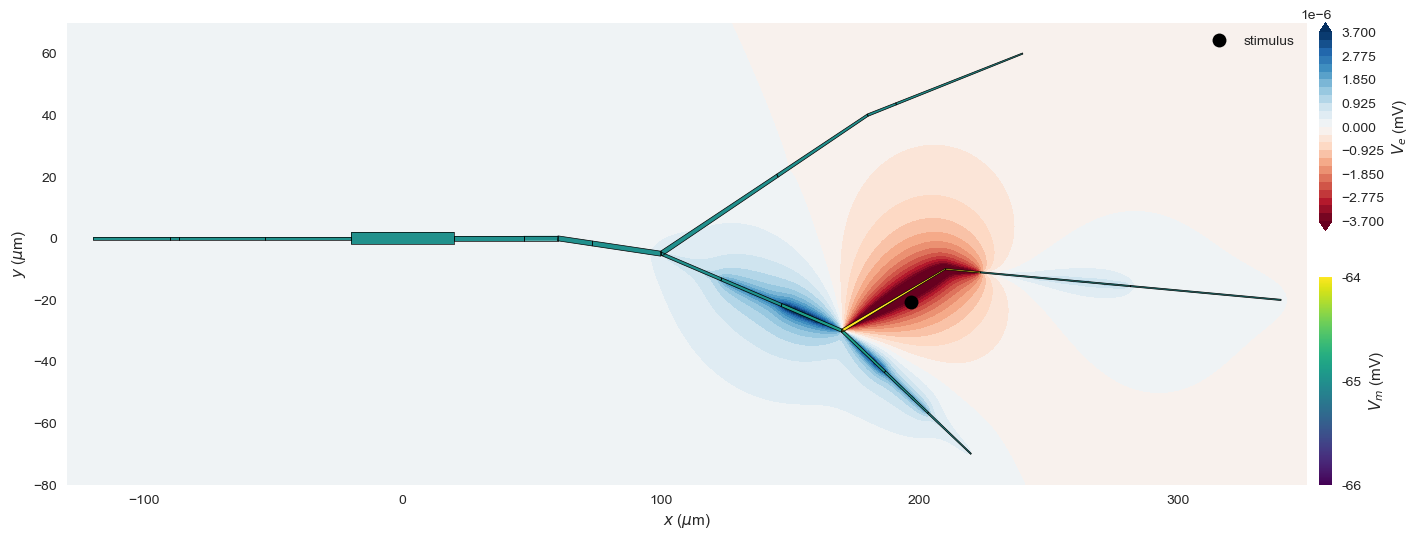

In [31]:
# show predictions at the last time point of simulation
time_index = -1

# color map
plt.rcParams['image.cmap'] = 'viridis'

# create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=100)


# plot contours of V_e
lim = float(f'{abs(V_e).max() / 3:.1e}')
levels = np.linspace(-lim, lim, 25)
im_V_e = ax.contourf(X, Y, V_e[:, time_index].reshape(X.shape),
                     cmap='RdBu',
                     levels=levels,
                     extend='both')

# V_e colorbar:
cb = colorbar(fig, ax, im_V_e, height=0.45, voffset=0.55)
cb.set_label('$V_e$ (mV)')

# add outline of each CV
vlims = [-66., -64.]
polycol = get_polycollection(cell_geometry, cell.vmem[:, time_index], vlims=vlims)
im_V_m = ax.add_collection(polycol)

cb2 = colorbar(fig, ax, im_V_m, height=0.45)
cb2.set_ticks([0, 0.5, 1])
cb2.set_ticklabels([-66, -65, -64])
cb2.set_label(r'$V_m$ (mV)')

# draw segment outlines
ax.add_collection(get_segment_outlines(cell_geometry))

# synapse location
ax.plot(cell.x[stim.idx].mean(), cell.y[stim.idx].mean(), 'ko', ms=10, label='stimulus')

ax.legend()

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_xlabel(r'$x$ ($\mu$m)')
ax.set_ylabel(r'$y$ ($\mu$m)')

## Notes on output:
The spatial discretization is here deliberately coarse with only `nseg=3` per section.
The soma consist of one section.
Hence the dendritic section receiving input about 1/6 of the way from its root 
is treated as 3 separate line sources with homogeneous current density per length unit each, even if 
the diameter and direction varies with position due to the fact 
that each compartment may  be composed of multiple pt3d segments. 

The parameter `nseg=3` to `custom_fun` above can be changed via `custom_fun_args=[{nseg: <integer>}]` to affect the number of compartments per section. 

The stimulus point is here not exactly on the shown geometry, but is on the mid-point between the start- and endpoint of the compartment. 